- Read data
- ID text col
* Vectorize
- Cluster
- Make column by assigining docs to cluster
- Write to csv
- ...
- DR ->
- Create project
- Upload data
- Ensure cluster feature is categorical?
- Run, compare to metrics without cluster

In [1]:
import pandas as pd
import numpy as np
import nlp_utils
import topic_model

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/10kDiabetes.csv')
df = df[df.diag_1_desc.notnull()].copy()
docs1 = df.diag_1_desc
docs2 = df.diag_2_desc
docs3 = df.diag_3_desc
# docs = docs[docs.notnull()]
docs = docs1 + docs2
docs.head()
docs1 = docs1.apply(lambda x: x.split())
docs2 = docs2.apply(lambda x: x.split() if type(x) == str else [])
docs3 = docs3.apply(lambda x: x.split() if type(x) == str else [])
# docs2 = docs2.apply(lambda x: x.split())
# docs = docs1 + docs2
docs1.head()
docsf = docs1 + docs2 + docs3
docs = docsf.apply(lambda x: ' '.join(x))

In [3]:
docs[docs.isnull()]

Series([], dtype: object)

In [4]:
# Params to build the vocab and topics
min_df = 10
max_df = .1
max_vocab_size = 5000
ngram_range=(1,1)

tm = topic_model.TopicModeller(model_type='NMF', vectorizer_type='localwise',
                               max_vocab_size=max_vocab_size, 
                               min_df=min_df, 
                               max_df=max_df, 
                               ngram_range=ngram_range)
tm.vectorize(docs)

Number of documents to process: 9998

Extracting Vectorizer features...
- Time: 2.748s.



Applying NMF for k=3 ...
- Time: 0.244s.
Applying NMF for k=4 ...
- Time: 0.195s.
Applying NMF for k=5 ...
- Time: 0.270s.
Applying NMF for k=6 ...
- Time: 0.298s.
Applying NMF for k=7 ...
- Time: 0.341s.
Applying NMF for k=8 ...
- Time: 0.324s.
Applying NMF for k=9 ...
- Time: 0.403s.
Applying NMF for k=10 ...
- Time: 0.429s.
Applying NMF for k=11 ...
- Time: 0.497s.
Applying NMF for k=12 ...
- Time: 0.545s.
Applying NMF for k=13 ...
- Time: 0.570s.
Applying NMF for k=14 ...
- Time: 0.620s.
Applying NMF for k=15 ...
- Time: 0.732s.
Applying NMF for k=16 ...
- Time: 0.724s.
Applying NMF for k=17 ...
- Time: 0.813s.
Applying NMF for k=18 ...
- Time: 0.877s.
Applying NMF for k=19 ...
- Time: 0.978s.
Applying NMF for k=20 ...
- Time: 1.036s.
Applying NMF for k=21 ...
- Time: 1.172s.
Applying NMF for k=22 ...
- Time: 1.206s.
Applying NMF for k=23 ...
- Time: 1.246s.
Applying NMF for k=24 ...
- Time: 1.472s.
Applying NMF for k=25 ...
- Time: 1.598s.
Applying NMF for k=26 ...
- Time: 1.703s.

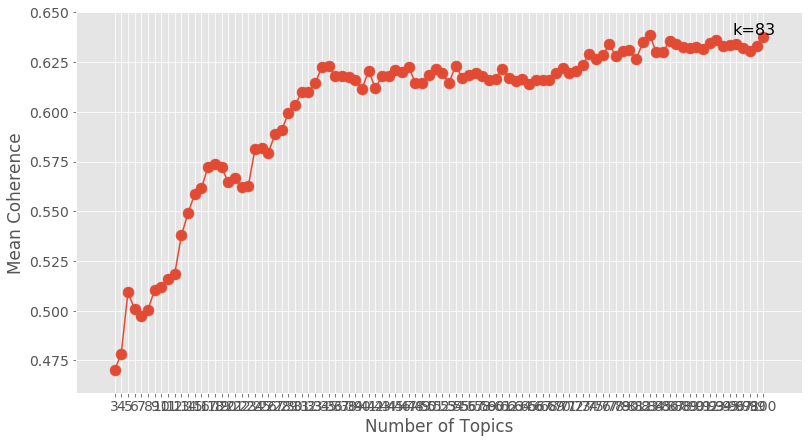

Topic 00: urinary, tract, infection, bladder, malnutrition, colic, trigone, moderate, hydronephrosis, hyperosmolarity, calculus, prostatitis, myositis, cystitis, candidiasis
Topic 01: myocardial, anterolateral, wall, old, vaginal, prolapse, myocarditis, sclerosis, hypertensive, toxic, multiple, examination, nonspecific, finding, dyspareunia
Topic 02: respiratory, abnormality, situ, old, joint, nephroptosis, headache, sarcoidosis, osteoporosis, rheumatoid, constipation, arthritis, myocardial, effusion, breast
Topic 03: postmyocardial, syndrome, raynaud, postcholecystectomy, basilar, artery, situ, cushing, old, nephrotic, hypertensive, neurological, proliferative, glomerulonephritis, aortic
Topic 04: hypertensive, stage, manifestation, renal, implant, mechanical, dermatitis, transplant, gouty, arthropathy, coma, peritonitis, cholecystitis, hyperosmolarity, encounter
Topic 05: organism, pneumonia, influenza, trachea, simple, candidiasis, mouth, dependence, cushing, situ, sarcoidosis, poly

In [9]:
# Calculate the optimal k using word2vec for coherence metric
k_topics = topic_model.plot_optimal_k(docs.tolist(), tm.document_term_mat, tm.vectorizer,
                           kmin=3, kmax=100, dim_size=500, min_df=min_df, 
                           max_vocab_size=max_vocab_size, num_top_terms=15,
                           model_file_path='./data/',
                           model_file_name='w2v-model.bin')

In [10]:
# tm.document_term_mat = nlp_utils.boost_doc_title_terms_tfidf(titles, tm.vectorizer, tm.document_term_mat, scale=1)
tm.fit(docs, k_topics=k_topics)

Fitting nmf model with 9998 documents.  Vectorizer: 
LocalwiseVectorizer(inflection_form='lemmer', max_df=0.1, max_features=5000,
          min_df=10, ngram_range=(1, 1))
- Time: 11.349s.

Reconstruction mse: 0.000446
Topic 0: urinary, tract, infection, bladder, streptococcus, gastrointestinal, malnutrition, colic, trigone, moderate, hydronephrosis, history, calculus, prostatitis, cystitis, myositis, candidiasis, implant, mouth, mechanical

Topic 1: myocardial, anterolateral, wall, old, vaginal, prolapse, myocarditis, sclerosis, hypertensive, toxic, multiple, dyspareunia, sarcoidosis, ophthalmic, hemopericardium, appendicitis, extradural, nontraumatic, vaccinia, postcholecystectomy

Topic 2: respiratory, abnormality, situ, old, joint, anxiety, headache, state, sarcoidosis, rheumatoid, constipation, arthritis, myocardial, effusion, breast, transplant, uterus, congenital, sensation, skin

Topic 3: postmyocardial, syndrome, raynaud, postcholecystectomy, basilar, artery, situ, cushing, old

In [11]:
# Generate the probability of each topic for each row (eg, job posting)
# and add the top topic and probability to the dataframe
def get_normalized_probs(topic_weights):
    '''
    Return the normalized topic cluseter weights for a given row
    '''
    topic_weights = topic_weights.flatten()
    #print row_idx
    if topic_weights.sum() == 0:
        probs = topic_weights
    else:
        probs = (topic_weights / topic_weights.sum())
    return probs

# For each row, get the topic weights, normalize, order by
# weight value, and store in a list to add to the dataframe 
top_topics = []
top_topic_weights = []
for row_idx in range(tm.W.shape[0]):
    W = tm.W[row_idx]
    probs = get_normalized_probs(W)
    
    ordered_idxs = np.argsort(probs)[::-1]
    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    
df['top_topic'] = top_topics
df['top_topic_weight'] = top_topic_weights

In [12]:
tm.W[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07984076,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.2465171 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [13]:
df

,rowID,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc,top_topic,top_topic_weight
0,1,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,...,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified",41,0.632282
1,2,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,...,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia,47,0.755358
2,3,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,...,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia,46,0.592081
3,4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,...,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...,46,0.529053
4,5,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,...,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis,53,0.819815
5,6,Caucasian,Male,[70-80),?,Elective,Discharged to home,Physician Referral,4,?,...,No,No,No,Yes,False,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia,Coronary atherosclerosis of unspecified type o...,82,0.000000
6,7,Caucasian,Female,[60-70),?,Elective,Expired,Physician Referral,6,MC,...,No,No,No,Yes,False,Cerebral thrombosis without mention of cerebra...,"Generalized nonconvulsive epilepsy, without me...",Acute kidney failure,13,0.643360
7,8,Caucasian,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,2,?,...,No,No,No,Yes,False,Other and unspecified noninfectious gastroente...,Diverticulosis of small intestine (without men...,Internal hemorrhoids without mention of compli...,61,0.568769
8,9,Caucasian,Male,[50-60),?,NaN,Discharged to home,NaN,3,?,...,No,No,No,No,False,"Congestive heart failure, unspecified",Endomyocardial fibrosis,Viral hepatitis A with hepatic coma,60,0.729416
9,10,Caucasian,Male,[60-70),?,Elective,Discharged to home,Physician Referral,5,?,...,No,No,No,Yes,True,Atherosclerosis of aorta,"Postoperative shock, unspecified","Postoperative shock, unspecified",31,0.592470


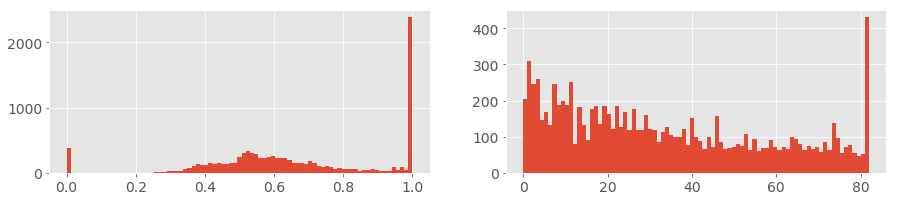

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
df.top_topic_weight.hist(bins=k_topics, ax=axs[0])
df.top_topic.hist(bins=k_topics, ax=axs[1])

Topic probabilities:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.12666592 0.         0.
 0.         0.         0.         0.         0.         0.
 0.20407084 0.         0.         0.         0.         0.63228221
 0.         0.         0.         0.         0.         0.
 0.         0.         0.03698103 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]

Top Topic: 41

Spinal stenosis in cervical region


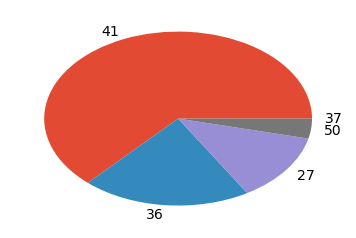

In [15]:
# Inspect record data
def inspect_record(rec_id):
    row_num = rec_id
    probs = get_normalized_probs(tm.W[row_num])
    ordered_idxs = np.argsort(probs)[::-1]
    top_topic = ordered_idxs[0]
    print ("Topic probabilities:\n%s\n" % probs)
    print ("Top Topic: %s\n" % top_topic)
#     print ("Top Tags:\n%s\n" % get_topic_top_tags(top_topic, 3))

    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    plt.pie(probs[ordered_idxs[:5]], labels=ordered_idxs[:5])
    print (df.iloc[row_num].diag_1_desc)
inspect_record(0)

In [16]:
df.columns

Index(['rowID', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_desc', 'diag_2_desc', 'diag_3_desc', 'top_topic',
       'top_topic_weight'],
      dtype='object')

In [17]:
df.to_csv('10kDiabetes_with_topics.csv')